### Import libraries and dataset:

In [242]:
%matplotlib widget
#%matplotlib inline
dpi=150

Import libraries:

In [294]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from ipywidgets import interact,IntSlider
from mpl_toolkits.axes_grid1 import make_axes_locatable

Import hdf5 file and save arrays to local variables:

In [3]:
#!gdown --folder 1k21VhLoonOnoxxXyswrmE45VIB4FF00n

In [18]:
filepath = 'content/banyuls_data/fish1_different_speeds.hdf5'
file=h5py.File(filepath, 'r')

In [19]:
dict(file.attrs)

{'age': 19, 'date': '2023-01-24', 'line': 'HUC'}

In [20]:
def printname(name):
    print(name)

file.visit(printname)

age
brain
brain/coordinates
brain/fluorescence
brain/times
stimulus
stimulus/direction
stimulus/speed
stimulus/times
tail
tail/coordinates
tail/deflection
tail/deflection_mean
tail/deflection_std
tail/times


In [21]:
def create_variable(name,node):
    if isinstance(node,h5py.Dataset):
        globals()[name.replace('/','_')]=node[...]

file.visititems(create_variable)

In [22]:
file.close()

In [253]:
brain_acquisition_rate=1/np.mean(np.diff(brain_times))
tail_acquisition_rate=1/np.mean(np.diff(tail_times))
stimulus_acquisition_rate=1/np.mean(np.diff(stimulus_times))

## Correlation between neural activity and external signals:

### Preprocessing the signal:

Let's start by finding neurons whose activity is correlated with tail movements.  Here we plot the rolling standard deviation of tail deflections, which is a measure of the amplitude of the oscillations of the tail:

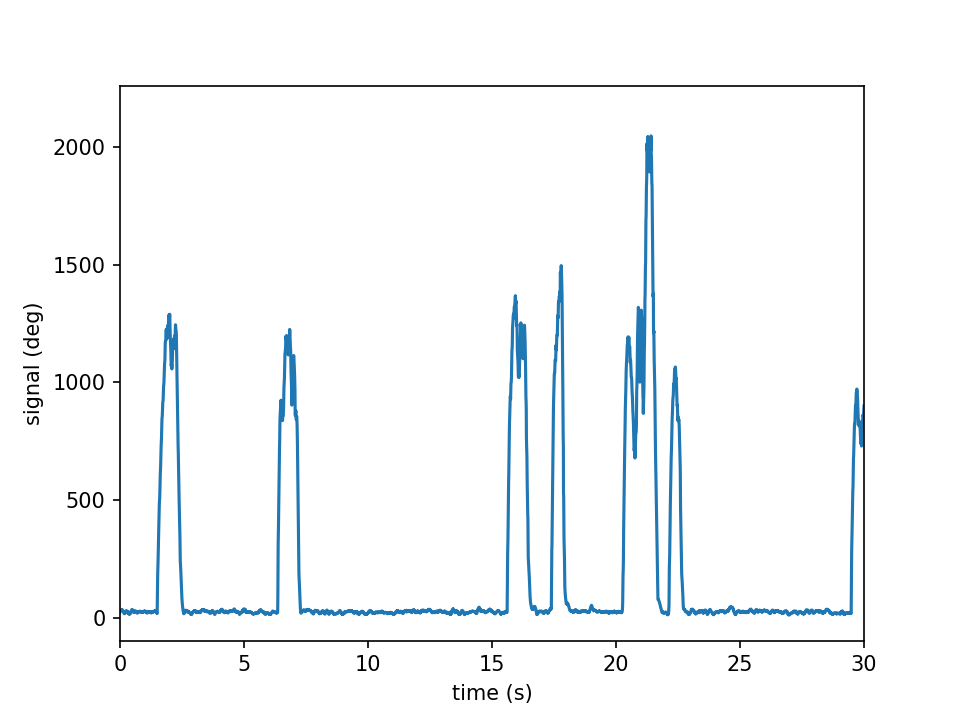

In [244]:
t1=0
t2=30 #tail_times[-1]
fig,ax=plt.subplots(dpi=dpi)
ax.plot(tail_times,tail_deflection_std)
ax.set_xlabel('time (s)')
ax.set_ylabel('signal (deg)')
ax.set_xlim(t1,t2)
#ax.set_ylim(0,100)
plt.show()

As you can see the signal is never actually zero because of noise in the tracking.  We can threshold the signal and set to zero all values below a certain level.  To choose this threshold we can zoom in on the noise to look at its typical values.

In [250]:
threshold=100
tail_deflection_std_thr=np.copy(tail_deflection_std)
tail_deflection_std_thr[tail_deflection_std<threshold]=0

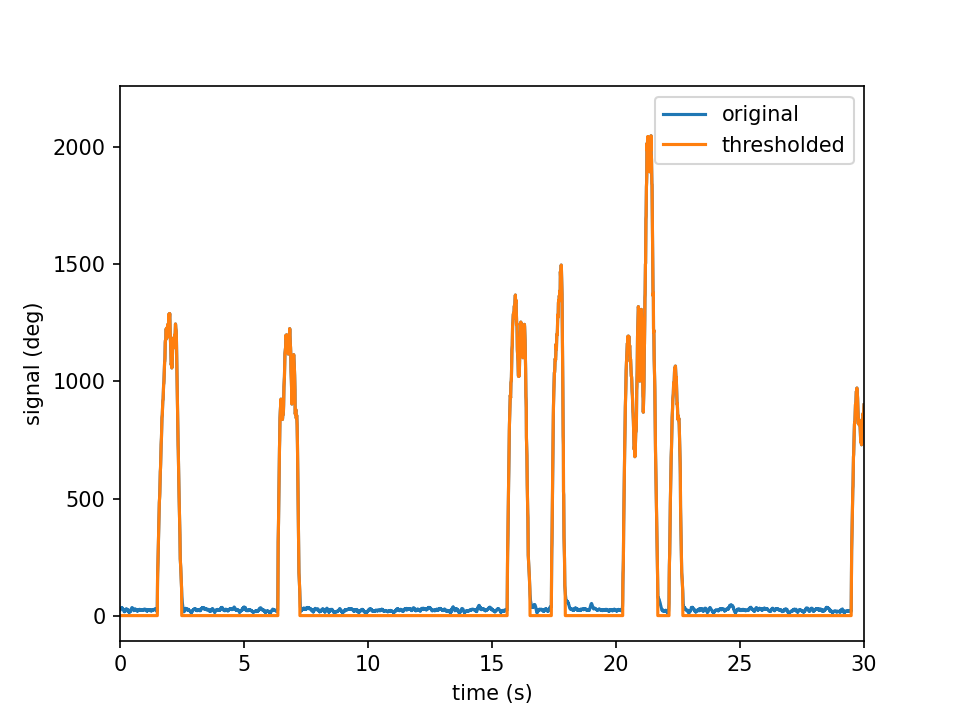

In [255]:
t1=0
t2=30 #tail_times[-1]
fig,ax=plt.subplots(dpi=dpi)
ax.plot(tail_times,tail_deflection_std,label='original')
ax.plot(tail_times,tail_deflection_std_thr,label='thresholded')
ax.set_xlabel('time (s)')
ax.set_ylabel('signal (deg)')
ax.set_xlim(t1,t2)
ax.legend()
#ax.set_ylim(0,100)
plt.show()

The fluorescence that we observe is a indicator of neural activity, it's a meausure of the concentration of calcium ions inside the neuron, which in turn is correlated with its firing rate.  Because of the unbinding kinetics of the calcium indicator, the fluorescence decays exponentially following an action potential with a characteristic time of $\tau \simeq 3$ s.

Fluorescence traces can be seen as a convolution of the spike train with a calcium impulse response function, which we'll take to be a simple exponential.

Because of this, if we want to compare our behavioral signal with the fluorescence traces, we'll have to convolve it with an exponential kernel of the form: $H(t) e^{-t/\tau}$

We start by defining the exponential kernel for the convolution, note that $t=0$ corresponds to the center of the array:

In [289]:
tau=3
T=10*tau
n_samples=int(T*tail_acquisition_rate)
kernel_times=np.linspace(-n_samples/tail_acquisition_rate,n_samples/tail_acquisition_rate,2*n_samples+1)
kernel=np.exp(-kernel_times/tau)
kernel[kernel_times<0]=0

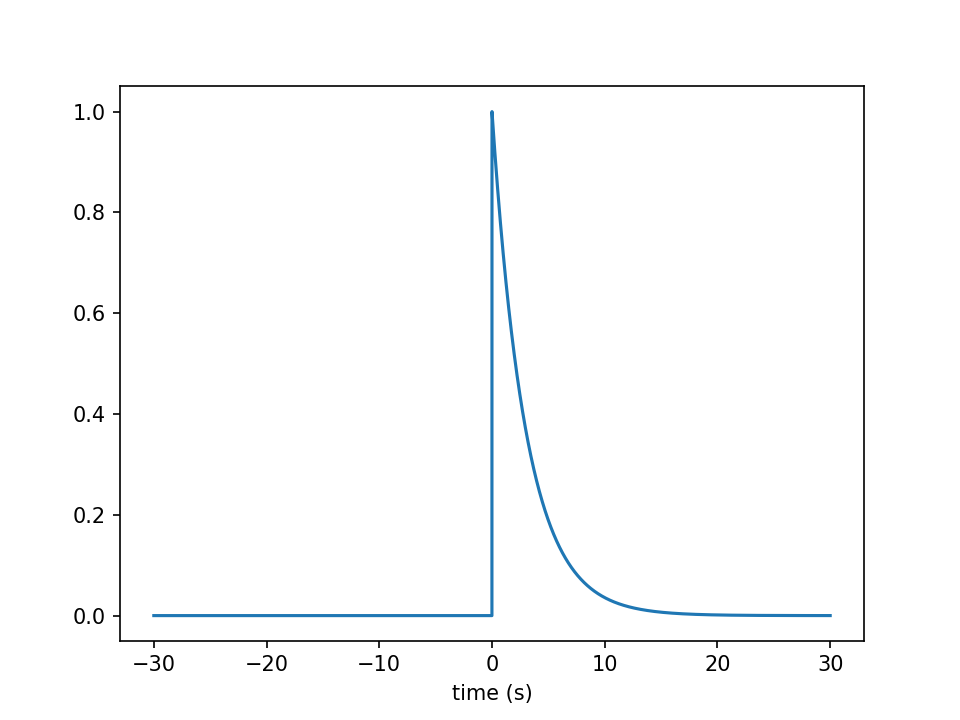

In [290]:
fig,ax=plt.subplots(dpi=dpi)
ax.plot(kernel_times,kernel)
ax.set_xlabel('time (s)')
plt.show()

Then we can perform the convolution:

In [291]:
from scipy.signal import convolve

In [292]:
tail_deflection_std_conv=signal.convolve(tail_deflection_std_thr,kernel,mode='same')/tail_acquisition_rate

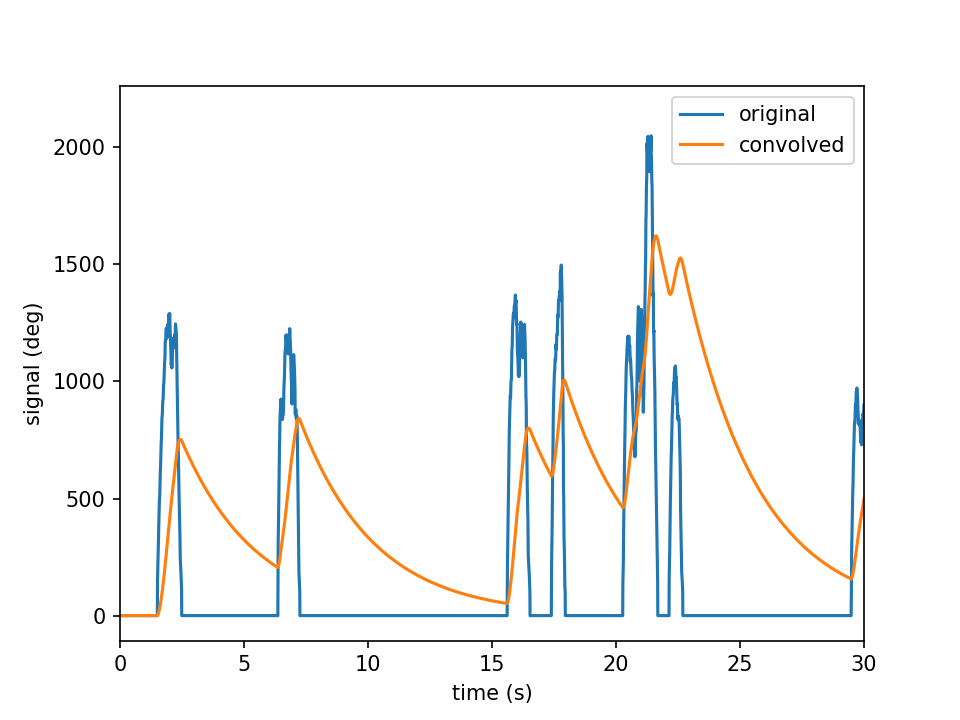

In [374]:
t1=0
t2=30 #tail_times[-1]
fig,ax=plt.subplots(dpi=dpi)
ax.plot(tail_times,tail_deflection_std_thr,label='original')
ax.plot(tail_times,tail_deflection_std_conv,label='convolved')
ax.set_xlabel('time (s)')
ax.set_ylabel('signal (deg)')
ax.set_xlim(t1,t2)
ax.legend()
plt.show()

Finally we have to resample the array at the same times where the fluorescence was measured, to do so we'll perform a linear interpolation:

In [375]:
from scipy.interpolate import interp1d

In [376]:
tail_deflection_std_conv_interp_f=interp1d(tail_times,tail_deflection_std_conv,kind='linear',fill_value='extrapolate')

In [377]:
tail_signal=tail_deflection_std_conv_interp_f(brain_times)

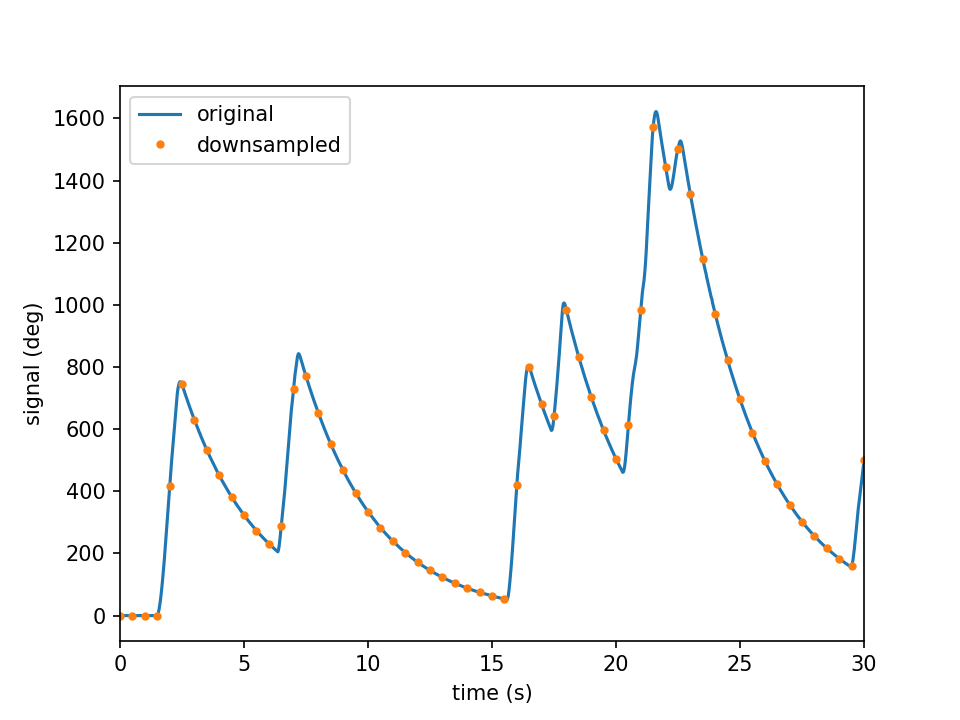

In [378]:
t1=0
t2=30 #tail_times[-1]
fig,ax=plt.subplots(dpi=dpi)
ax.plot(tail_times,tail_deflection_std_conv,label='original')
ax.plot(brain_times,tail_signal,'.',label='downsampled')
ax.set_xlabel('time (s)')
ax.set_ylabel('signal (deg)')
ax.set_xlim(t1,t2)
ax.legend()
plt.show()

### Calculating correlations:

As a measure of correlation we can calculate the covariance between the preprocessed tail amplitude and the neural fluorescence traces.  

$$Cov(x,y)=\overline{(x-\bar{x})\cdot(y-\bar{y})}$$

Regions where both signals are larger or smaller than their averages give positive contibutions, whereas regions where one is larger and the other is smaller give negative contributions.  This way correlated signals we'll have a positive covariance, anticorrelated signals a negative covariance, and uncorrelated signals a covariance that is close to zero (how much?).

The fluorescence traces are already centered around 0:

In [320]:
np.allclose(np.mean(brain_fluorescence,axis=1),0)

True

In [533]:
tail_signal_centered=tail_signal-np.mean(tail_signal)
covariance=np.zeros(len(brain_fluorescence))
for i in range(len(brain_fluorescence)):
    covariance[i]=np.mean(tail_signal_centered*brain_fluorescence[i])

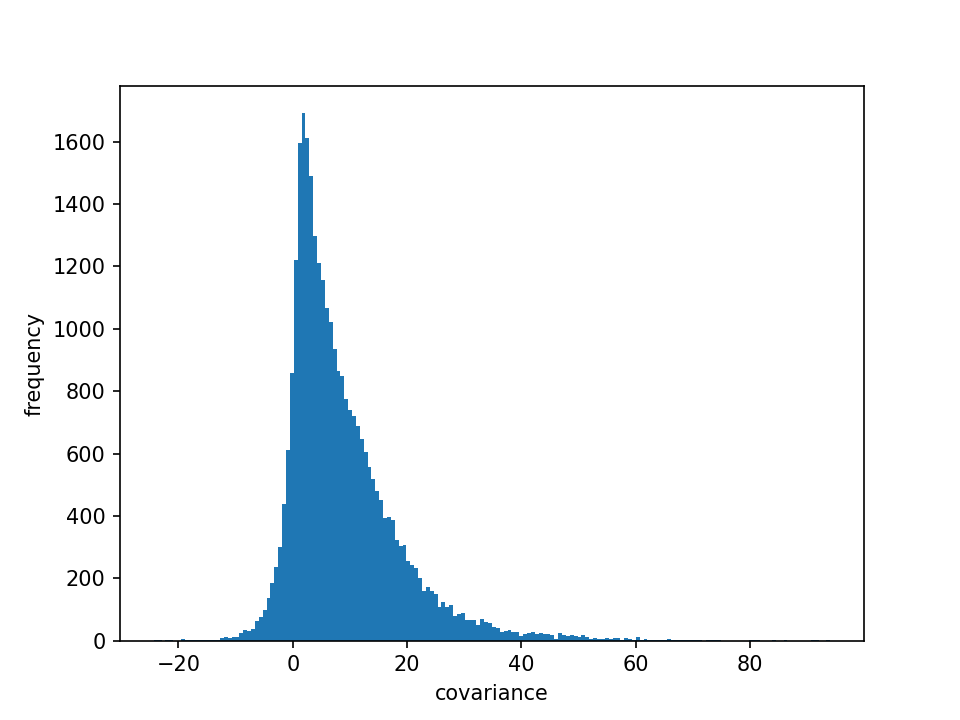

In [534]:
fig,ax=plt.subplots(dpi=dpi)
ax.hist(covariance,bins='auto')
ax.set_xlabel('covariance')
ax.set_ylabel('frequency')
plt.show()

### Calculating statistical significance:

How do we know if a covariance value is significantly larger than zero?
We need a way to define a threshold above which covariances are satistically significant.

We would like to know the distribution of covariances in the case where the two signals are uncorrelated.
We can estimate it with a method called bootstrapping, it consists in resampling our signal in order to create new signals with the same statistics.
As we're working with time series, adjacent samples are not independent but correlated in time, thus we're going to resample blocks of consecutive samples in order to preserve the structure on short times.

We choose a method called stationary bootstrap, in which the size of the blocks is randomized as well.

In [535]:
def stationary_bootstrap(array,average_block_size):
    l=len(array)
    p=1/average_block_size
    resampled_array=np.zeros(l)
    j=np.random.randint(l)
    resampled_array[0]=array[j]
    for i in range(1,l):
        if np.random.random()<1-p:
            j=(j+1)%l
        else:
            j=np.random.randint(l)
        resampled_array[i]=array[j]
    return resampled_array

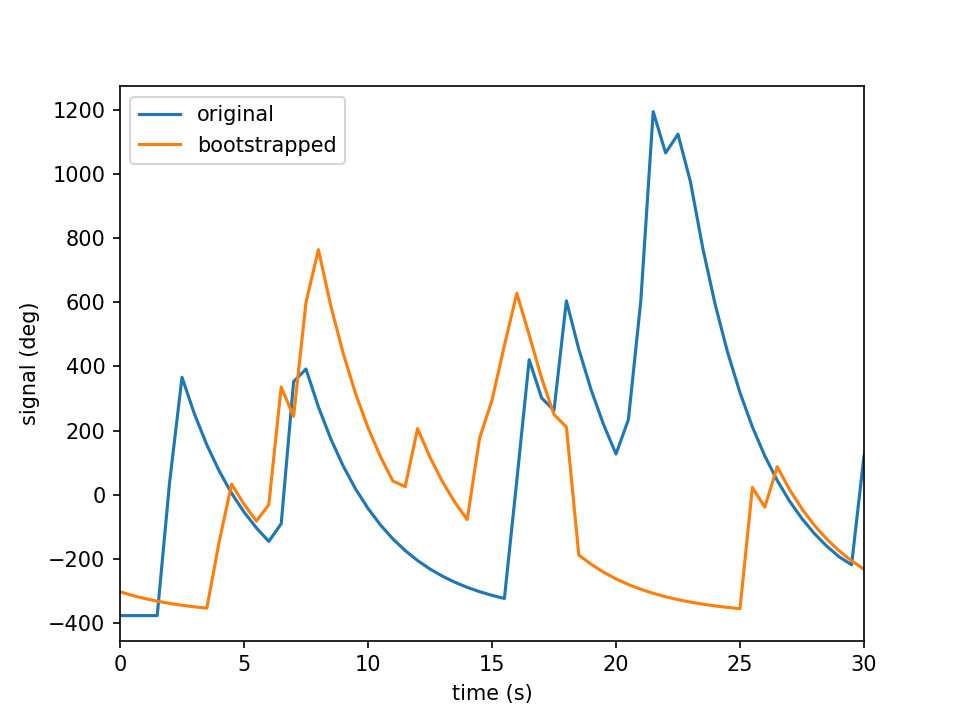

In [536]:
average_block_duration=30
tail_signal_resampled=stationary_bootstrap(tail_signal_centered,average_block_duration*brain_acquisition_rate)
t1=0
t2=30 #tail_times[-1]
fig,ax=plt.subplots(dpi=dpi)
ax.plot(brain_times,tail_signal_centered,label='original')
ax.plot(brain_times,tail_signal_resampled,label='bootstrapped')
ax.set_xlabel('time (s)')
ax.set_ylabel('signal (deg)')
ax.set_xlim(t1,t2)
ax.legend()
plt.show()

Now we can create a null distribution of covariances using the bootstrapped signals, we expect the covariance to follow this distribution for neural activity that is independent of the behavioral signal:

In [537]:
n_resamples=20
covariance_bootstrap=np.zeros(n_resamples*len(brain_fluorescence)) 
for n in range(n_resamples):
    tail_signal_resampled=stationary_bootstrap(tail_signal_centered,average_block_duration*brain_acquisition_rate)
    for i in range(len(brain_fluorescence)):
        covariance_bootstrap[n*len(brain_fluorescence)+i]=np.mean(tail_signal_resampled*brain_fluorescence[i])

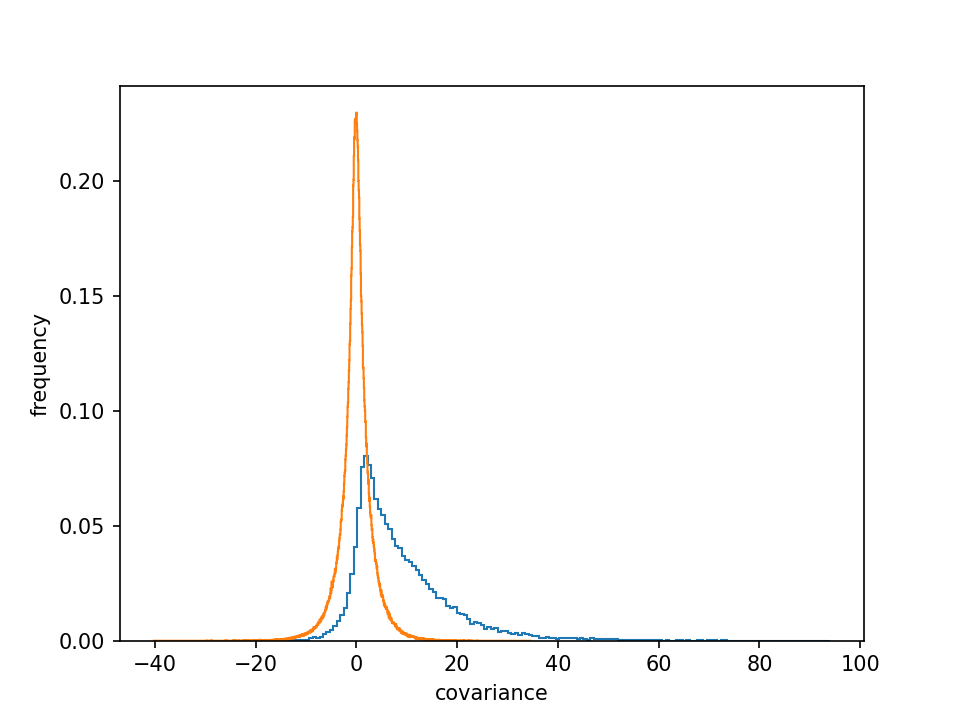

In [538]:
fig,ax=plt.subplots(dpi=dpi)
ax.hist(covariance,bins='auto',histtype='step',density=True,label='original')
ax.hist(covariance_bootstrap,bins='auto',histtype='step',density=True,label='bootstrapped')
ax.set_xlabel('covariance')
ax.set_ylabel('frequency')
plt.show()

Now that we have an estimate of the null distribution, we can calculate the p-value associated to a certain covariance, it's the probability of obtaining an even larger value of covariance according to the null distribution:

In [539]:
covariance_bootstrap_sorted=np.sort(covariance_bootstrap)
covariance_bootstrap_sorted=np.append(covariance_bootstrap_sorted,covariance_bootstrap_sorted[-1])
probability_of_smaller_values=np.arange(len(covariance_bootstrap_sorted))/(len(covariance_bootstrap_sorted)-1)
empirical_distribution_function=interp1d(covariance_bootstrap_sorted,probability_of_smaller_values,kind='next',fill_value='extrapolate')
pvalue=np.zeros(len(brain_fluorescence))
for i in range(len(brain_fluorescence)):
    pvalue[i]=1-empirical_distribution_function(covariance[i])

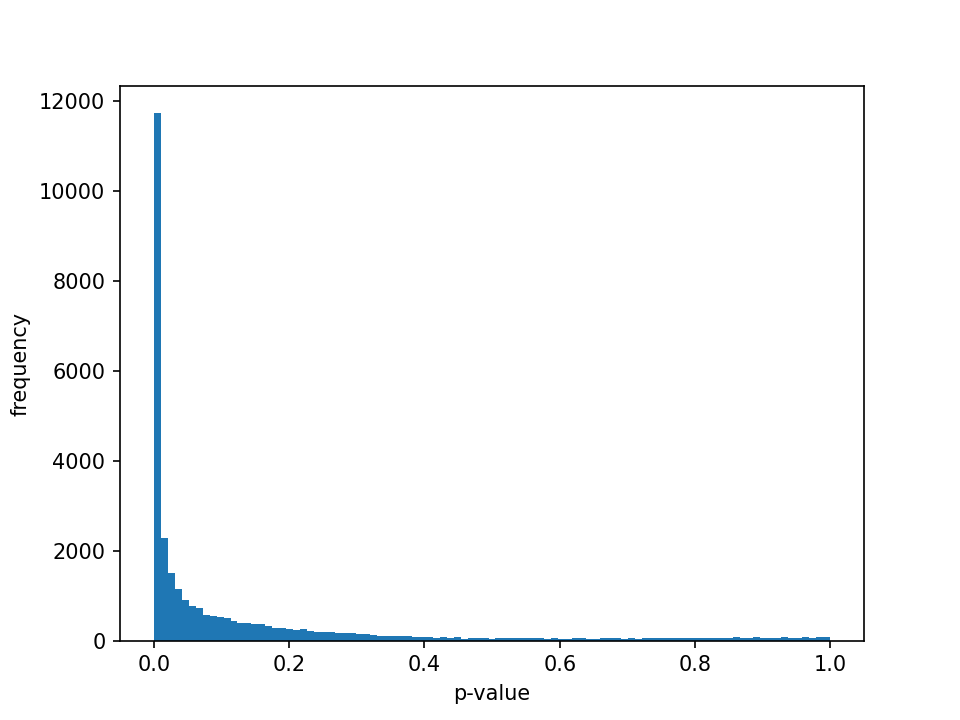

In [540]:
fig,ax=plt.subplots(dpi=dpi)
ax.hist(pvalue,bins='auto')
ax.set_xlabel('p-value')
ax.set_ylabel('frequency')
plt.show()

Normally, one would consider as statistically significant a covariance value for which the p-value is smaller than a certain threshold fixed before the experiment.  This would be ok for a single neuron, but in our case we have to be more careful as we're testing multiple hypothesis simultaneously.

What we can do is to control the false discovery rate, expected fraction of false positives, neurons that are incorrectly classified as significantly correlated.  We can implement the Benjamini–Hochberg procedure, which ensures that the false discovery rate is smaller than a given threshold $\alpha$.  If we're testing $m$ hypotheses we have to sort the p-values in increasing order and find the largest index $k$ such that $P_k \leq \frac{k}{m}\alpha$.  Then we  can reject the null hypothesis of uncorrelated signals for the $k$ neurons with the smallest p-values.

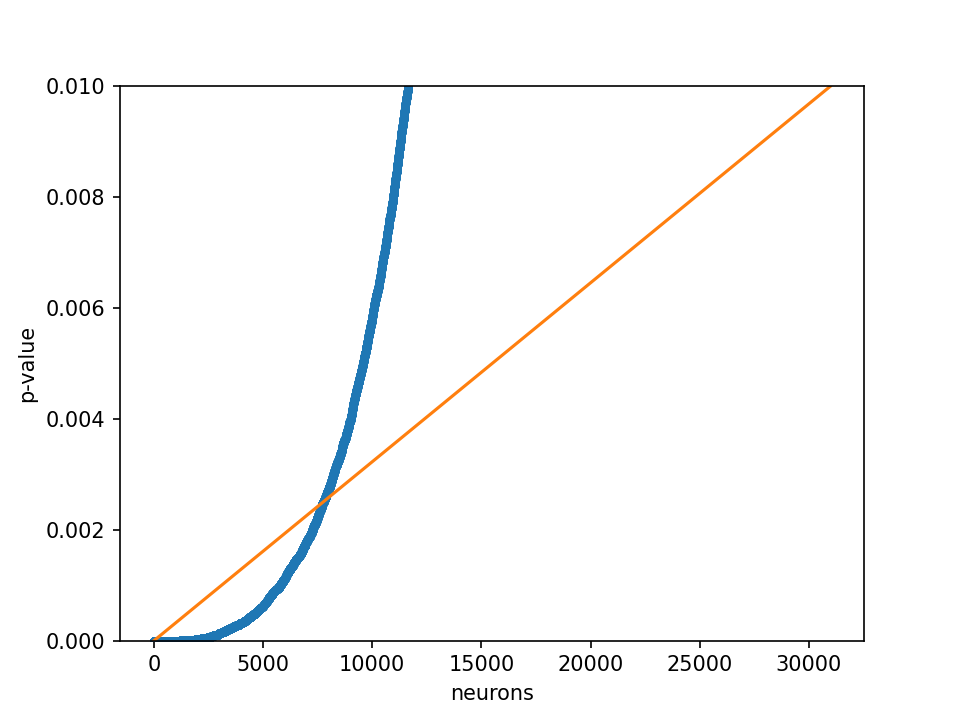

In [548]:
alpha=0.01
fig,ax=plt.subplots(dpi=dpi)
ax.plot(np.sort(pvalue),'.')
ax.plot((np.arange(len(pvalue))+1)/len(pvalue)*alpha)
ax.set_ylim(0,alpha)
ax.set_xlabel('neurons')
ax.set_ylabel('p-value')
plt.show()

The number of significantly correlated neurons according to the Benjamini-Hochberg procedure is:

In [549]:
indices=np.where(np.sort(pvalue)<=(np.arange(len(pvalue))+1)/len(pvalue)*alpha)[0]
if len(indices)==0:
    n_rejected_neurons=0
else:
    n_rejected_neurons=np.max(indices)+1
n_rejected_neurons

7775

## Linear regression:

In [19]:
from sklearn.linear_model import LinearRegression

In [36]:
X=np.array([center(tail_amplitude_convolved),center(stimulus_speed_convolved)]).T

In [49]:
weights=np.zeros((len(brain_fluorescence),X.shape[1]))
scores=np.zeros(len(brain_fluorescence))
for i in range(len(brain_fluorescence)):
    reg=LinearRegression().fit(X,brain_fluorescence[i])
    weights[i]=reg.coef_
    scores[i]=reg.score(X,brain_fluorescence[i])

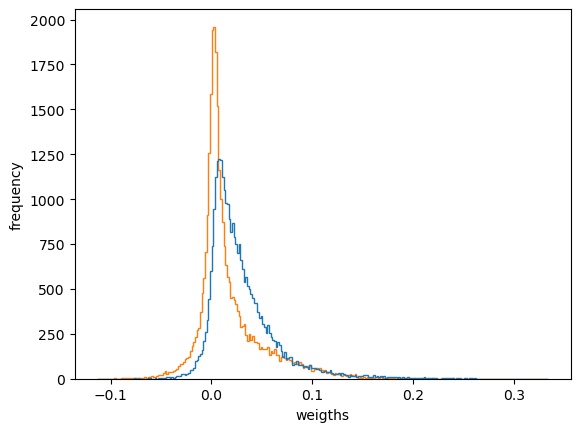

In [50]:
#plot histogram of covariances
fig=plt.figure()
plt.hist(weights,bins='auto',histtype='step')
plt.xlabel('weights')
plt.ylabel('frequency')
plt.show()

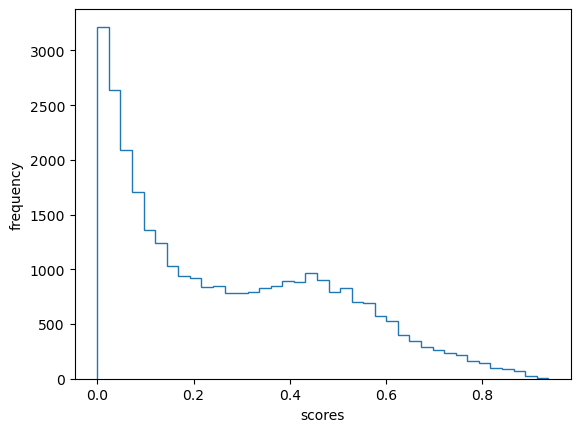

In [51]:
#plot histogram of covariances
fig=plt.figure()
plt.hist(scores,bins='auto',histtype='step')
plt.xlabel('scores')
plt.ylabel('frequency')
plt.show()

Find the null distribution of covariances by calculating the covariances with cyclically shifted signals:

In [53]:
n_shifts=5 #number of shifts to construct the null distribution
shifts=(len(brain_times)*np.sqrt(2)*(np.arange(n_shifts)+1)).astype(int)

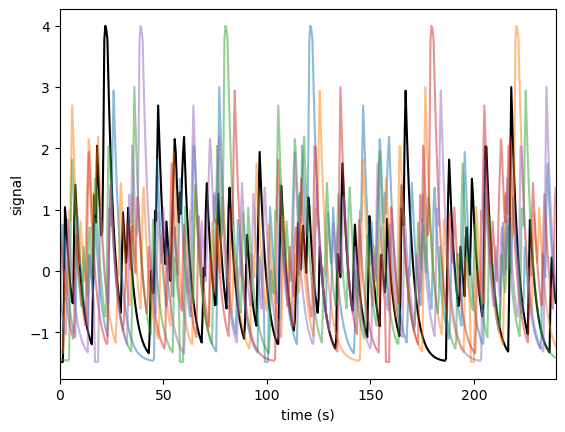

In [71]:
#plot histogram of correlations with shifted signals
fig=plt.figure()
plt.plot(brain_times,X[:,0],'k')
for shift in shifts:
    plt.plot(brain_times,np.roll(X,shift,axis=0)[:,0],alpha=0.5)
plt.xlim(brain_times[0],brain_times[-1])
plt.xlabel('time (s)')
plt.ylabel('signal')
plt.show()

In [72]:
weights_shifted=[]
scores_shifted=[]
for shift in shifts:
    X_shifted=np.roll(X,shift,axis=0)
    for i in range(len(brain_fluorescence)):
        reg=LinearRegression().fit(X_shifted,brain_fluorescence[i])
        weights_shifted.append(reg.coef_)
        scores_shifted.append(reg.score(X_shifted,brain_fluorescence[i]))

In [74]:
weights_shifted=np.array(weights_shifted)
scores_shifted=np.array(scores_shifted)

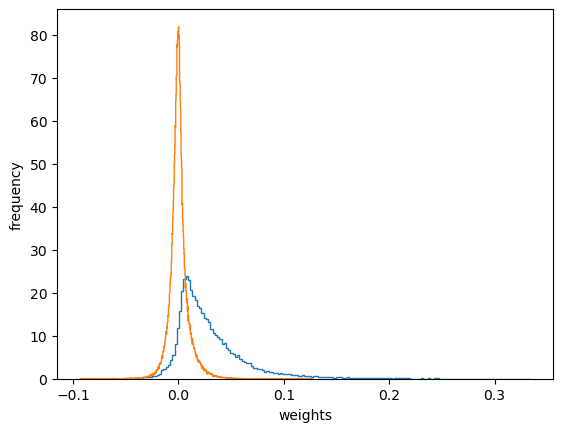

In [93]:
#plot histogram of covariance with shifted signals
fig=plt.figure()
plt.hist(weights[:,0],bins='auto',histtype='step',density=True)
plt.hist(weights_shifted[:,0],bins='auto',histtype='step',density=True)
plt.xlabel('weights')
plt.ylabel('frequency')
plt.show()

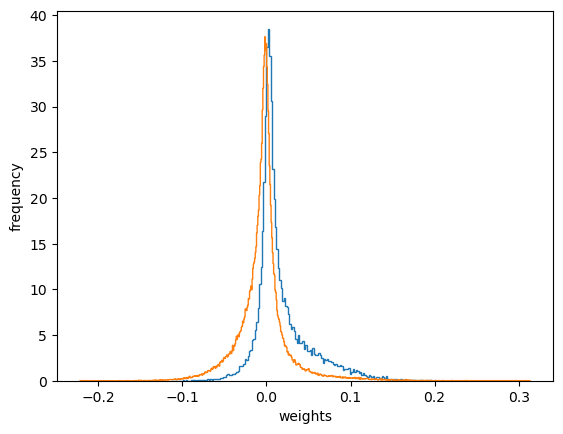

In [94]:
#plot histogram of covariance with shifted signals
fig=plt.figure()
plt.hist(weights[:,1],bins='auto',histtype='step',density=True)
plt.hist(weights_shifted[:,1],bins='auto',histtype='step',density=True)
plt.xlabel('weights')
plt.ylabel('frequency')
plt.show()

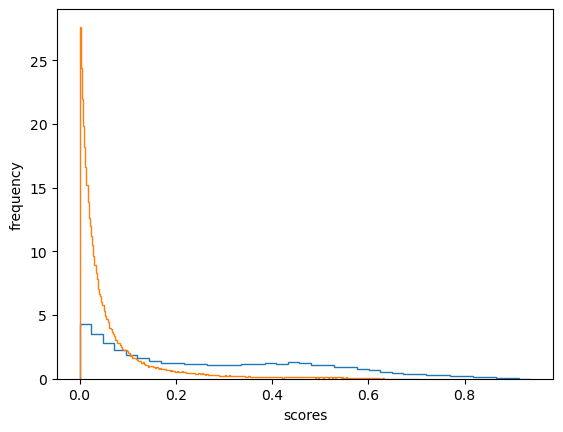

In [79]:
#plot histogram of covariance with shifted signals
fig=plt.figure()
plt.hist(scores,bins='auto',histtype='step',density=True)
plt.hist(scores_shifted,bins='auto',histtype='step',density=True)
plt.xlabel('scores')
plt.ylabel('frequency')
plt.show()

In [80]:
#calculate p-values
x=-np.sort(-np.array(scores_shifted))
y=np.arange(len(x))/len(x)
f_pvalue=interp1d(x,y,kind='previous',fill_value='extrapolate')
pvalue=np.zeros(len(brain_fluorescence))
for n in range(len(brain_fluorescence)):
    pvalue[n]=f_pvalue(scores[n])

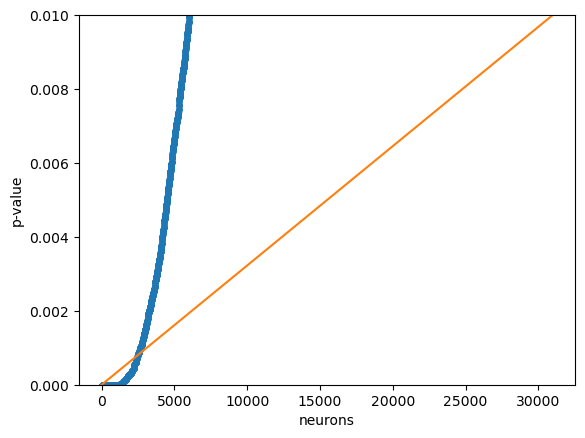

In [81]:
fdr=0.01#false discovery rate
fig=plt.figure()
plt.plot(np.sort(pvalue),'.') #ordered p-values
plt.plot((np.arange(len(pvalue))+1)/len(pvalue)*fdr) #benjamini-hochberg line
plt.ylim(0,fdr)
plt.xlabel('neurons')
plt.ylabel('p-value')
plt.show()

Number of neurons whose activity has a higher-than-chance covariance with the tail deflection amplitude:

In [82]:
#number of significantly correlated neurons according to the benjamini-hochberg procedure:
if len(np.where(np.sort(pvalue)<(np.arange(len(pvalue))+1)/len(pvalue)*fdr)[0])==0:
    n_rejected_neurons=0
else:
    n_rejected_neurons=np.max(np.where(np.sort(pvalue)<(np.arange(len(pvalue))+1)/len(pvalue)*fdr)[0])+1
n_rejected_neurons

2505

In [84]:
indices=np.argsort(-scores) #indices of all neurons sorted with decreasing correlation
indices_thr=indices[:n_rejected_neurons] #indices of significantly correlated neurons
characteristic=np.zeros(len(brain_fluorescence))
characteristic[indices_thr]=1 #it returns 1 on significantly correlated neurons

In [85]:
#fluorescence traces ordered with decreasing covariance
def f(neuron):
    plt.close()
    fig,ax=plt.subplots(dpi=150)
    ax.plot(brain_times,signal,c='black')
    ax.plot(brain_times,brain_fluorescence[indices[neuron]],'g')
    ax.set_xlim(brain_times[0],brain_times[-1])
    ax.set_xlabel('time (s)')
    ax.set_ylabel('$\Delta F/F$')
    plt.show()
    
interact(f,neuron=IntSlider(value=0,min=0,max=len(brain_fluorescence)-1,step=1));

interactive(children=(IntSlider(value=0, description='neuron', max=30970), Output()), _dom_classes=('widget-in…

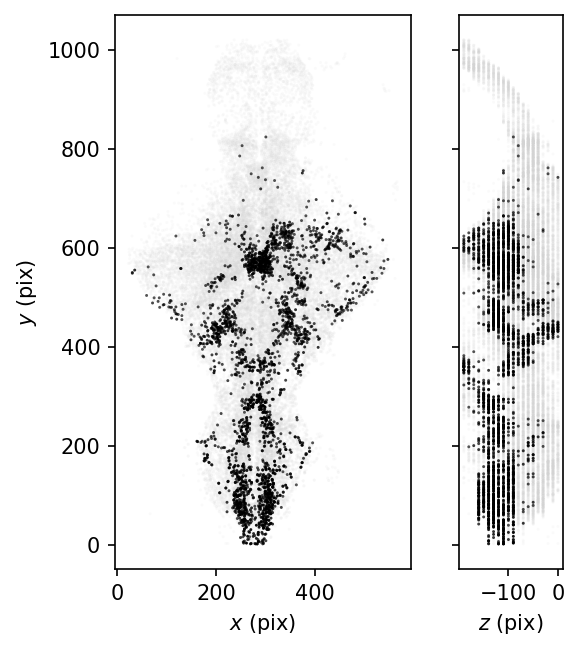

In [87]:
#plot neuron positions colored according to the corresponding covariance
fig, (ax1, ax2) = plt.subplots(1,2,dpi=150,sharey=True)
plt.subplots_adjust(wspace=-0.5)

mask=characteristic.astype(bool)
opacity=scores/np.max(scores)
alphas=opacity[mask]
s=2
c='k'

ax1.scatter(brain_coordinates[0,~mask],brain_coordinates[1,~mask],s=s,c='lightgrey',alpha=0.1,edgecolors='none')
ax1.scatter(brain_coordinates[0,mask],brain_coordinates[1,mask],s=s,c=c,alpha=alphas,edgecolors='none')

ax1.set_aspect('equal')
ax1.set_xlabel('$x$ (pix)')
ax1.set_ylabel('$y$ (pix)')

ax2.scatter(brain_coordinates[2,~mask],brain_coordinates[1,~mask],s=s,c='lightgrey',alpha=0.1,edgecolors='none')
ax2.scatter(brain_coordinates[2,mask],brain_coordinates[1,mask],s=s,c=c,alpha=alphas,edgecolors='none')

ax2.set_aspect('equal')
ax2.set_xlabel('$z$ (pix)')

plt.show()

In [89]:
#plots layer by layer
zs=np.unique(brain_coordinates[2])
zs=-np.sort(-zs) #ordered heights of the layers

mask=characteristic.astype(bool)
opacity=scores/np.max(scores)

def f(layer):
    plt.close()
    fig,ax=plt.subplots(dpi=150)
    s=1
    offmask_l=(brain_coordinates[2]==zs[layer])&(~mask)
    mask_l=(brain_coordinates[2]==zs[layer])&(mask)
    xlayer=brain_coordinates[0,offmask_l]
    ylayer=brain_coordinates[1,offmask_l]
    ax.scatter(xlayer,ylayer,s=s,c='lightgrey',alpha=0.5)
    xlayer=brain_coordinates[0,mask_l]
    ylayer=brain_coordinates[1,mask_l]
    alphas=opacity[(brain_coordinates[2]==zs[layer])&(mask)]
    if len(xlayer)>0:
        ax.scatter(xlayer,ylayer,s=s,c='black',alpha=alphas)

    ax.set_aspect('equal')
    ax.set_xlim(np.min(brain_coordinates[0]),np.max(brain_coordinates[0]))
    ax.set_ylim(np.min(brain_coordinates[1]),np.max(brain_coordinates[1]))
    ax.set_title('$z = $'+str(zs[layer]))
    ax.set_xlabel('$x$ (pix)')
    ax.set_ylabel('$y$ (pix)')
    plt.show()
    
interact(f,layer=IntSlider(value=0,min=0,max=len(zs)-1,step=1));

interactive(children=(IntSlider(value=0, description='layer', max=19), Output()), _dom_classes=('widget-intera…

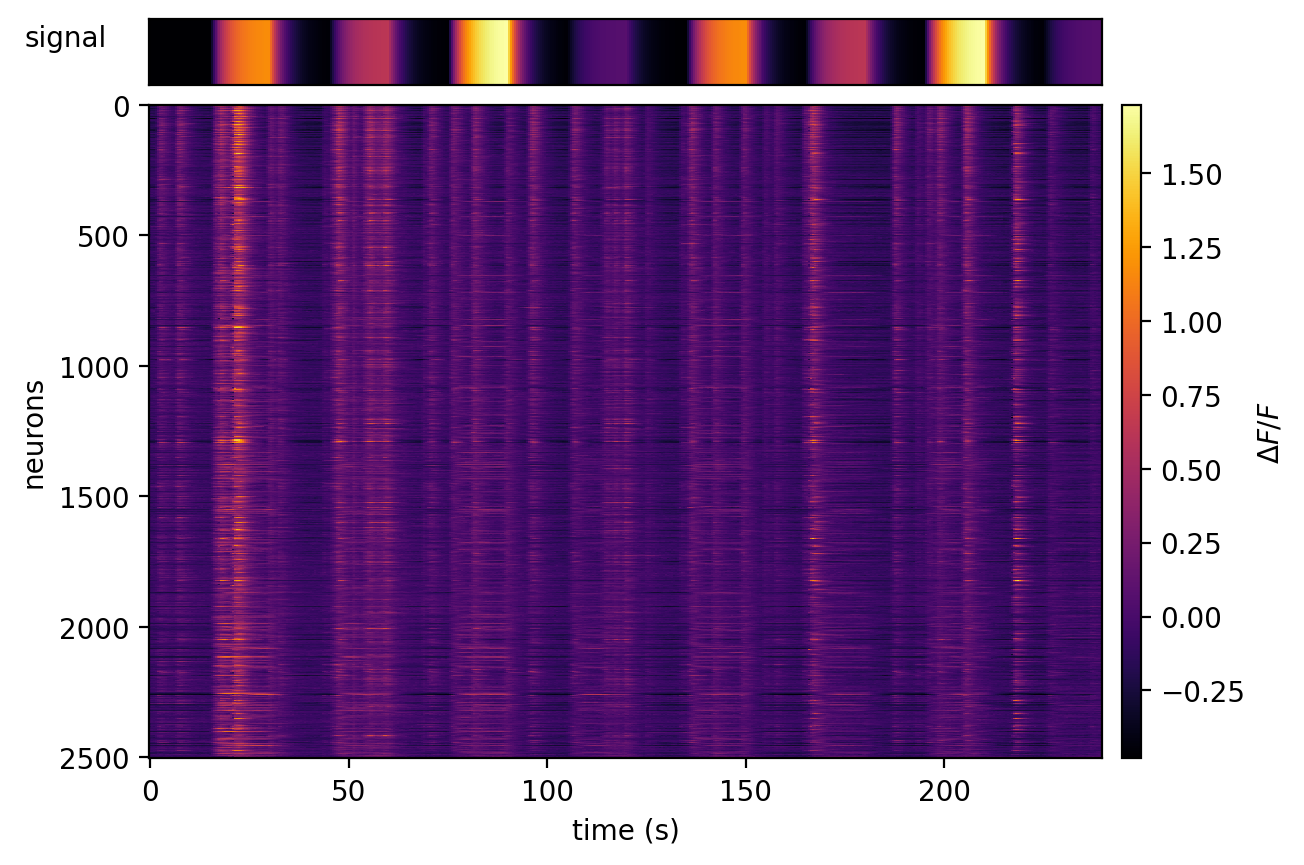

In [90]:
#show fluorescence traces with colormap ordered by decreasing covariance
fig,ax=plt.subplots(dpi=200)
divider=make_axes_locatable(ax)

tax=divider.append_axes('top', size="10%", pad=0.1)
cax=divider.append_axes('right', size="2%", pad=0.1)

dt=(brain_times[-1]-brain_times[0])/len(brain_times)

im1=tax.imshow(np.reshape(signal,(1,-1)),cmap='inferno',interpolation='none',aspect='auto',extent=[brain_times[0]-dt/2,brain_times[-1]+dt/2,len(indices_thr)-0.5,-0.5])

tax.tick_params(axis='both',which='both',bottom=False,left=False,labelbottom=False,labelleft=False)
tax.set_ylabel('signal',rotation=0,labelpad=30)

im2=ax.imshow(brain_fluorescence[indices_thr][:,:],cmap='inferno',interpolation='none',aspect='auto',extent=[brain_times[0]-dt/2,brain_times[-1]+dt/2,len(indices_thr)-0.5,-0.5])

cbar=plt.colorbar(im2,cax=cax)
cbar.set_label(r'$\Delta F/F$')

ax.set_xlabel('time (s)')
ax.set_ylabel('neurons')

plt.show()